# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Accuracy-Calculation-COST-323" data-toc-modified-id="Accuracy-Calculation-COST-323-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Accuracy Calculation COST 323</a></div><div class="lev2 toc-item"><a href="#Description-of-the-accuracy-calculation-sheet" data-toc-modified-id="Description-of-the-accuracy-calculation-sheet-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Description of the accuracy calculation sheet</a></div><div class="lev2 toc-item"><a href="#Source" data-toc-modified-id="Source-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Source</a></div><div class="lev3 toc-item"><a href="#Tolarance-classes" data-toc-modified-id="Tolarance-classes-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Tolarance classes</a></div><div class="lev2 toc-item"><a href="#Test" data-toc-modified-id="Test-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Test</a></div><div class="lev1 toc-item"><a href="#References" data-toc-modified-id="References-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>References</a></div>

# Accuracy Calculation COST 323

The accuracy calculation can be consulting in \cite{jacob1998european}. In the 
accuracy calculation sheet provided by COST 323, we can extract the follow
information:

## Description of the accuracy calculation sheet

Initial verification: (Yes=1, No=0)

Sheet Fields (the header columns stay in line 8 and 9 into the sheet): 

* SYSTEM/Entity (column A/Index), 
* Number  (column B) [Input], 
* Identified (column C) [Input], 
* Mean (column D) [Input], 
* Std deviat (column E) [Input], 
* p_o (column F), 
* Class (column G), 
* d (column H), 
* d_min (column I) [Input/Minimization Solver Output],
* d_c (column J),
* class (column K), 
* p (column L) - related to column I, 
* p (column M) -  related to column H, 
* p' (column N), 
* Accepted (column O)

Test plan

* "r1"=full repeatability
* "r2"=extended repeatability
* "rr1"=limited reproducibility
* "rr2"=full reproducibility

Env

* "I"=environmental repeatability
* "II"=environmental limited reproducibility
* "III"=environmental full reproducibility

Description:

* Number: number of measured vehicles/axles/etc. which are valid and kept for the
test (may be less than those of the test plan)
* Identified: percentage of the total number of measured vehicles/axles/etc. 
which are valid and kept for the test (enter by hand)
* Mean, Std Deviation: mean and standard deviation of the individual relative 
errors with respect to the static reference loads
* p_o: minimum required level of confidence within the class tolerance d, i.e. 
of the confidence interval [-d;d]
* d_min: for each criterion, tolerance (half width of the confidence interval) 
which exactly corresponds to the minimum required level of confidence p_o
* d_c: "best acceptable interpolated class for the given criterion", i.e. 
tolerance on the GW which exactly corresponds to the d_min of the given 
criterion

## Source

In [1]:
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.optimize import root, fsolve
from scipy import stats

import numba as nb
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
def calc_min_confidence(
    data: pd.DataFrame, test_plan: str, env_condition: str
):
    """
    =100*(2*NORMDIST(\\
      IF(\$B\$5="r1";2,675/IF(\$D\$5="III";1,1;IF(\$D\$5="II";1,05;1));\\
      IF(\$B\$5="r2";2,36/IF(\$D\$5="III";1,1;IF(\$D\$5="II";1,05;1));\\
        IF(\$B\$5="RR1";2,155/IF(\$D\$5="III";1,1;IF(\$D\$5="II";1,05;1));\\
          IF(\$B\$5="RR2";2/IF(\$D\$5="III";1,1;IF(\$D\$5="II";1,05;1));0))\\
      ))-TINV(0,05;B9-1)/SQRT(B9);0;1;TRUE())-1)
      
    """
    # data = data.copy()
    
    def _calc(v: float):
        
        if env_condition=='I':
            _v = 1 
        elif env_condition=='II':
            _v = 1.05
        elif env_condition=='III':
            _v = 1.1 
        else:
            raise Exception('INVALID_ENV_CONDITION')
                      
        if test_plan=='R1':
            _v = 2.675/_v
        elif test_plan=='R2':
            _v = 2.36/_v
        elif test_plan=='RR1':
            _v = 2.155/_v
        elif test_plan=='RR2': 
            _v = 2/_v
        else:
            raise Exception('INVALID_TEST_PLAN')

        # in isf, the probabity is divided by 2 
        # because in excel TINV is 2-side tail
        return 100 * (
            2 * norm.cdf(_v-stats.t.isf(0.05/2, v-1)/np.sqrt(v), 0, 1)-1
        )
    
    test_plan = test_plan.upper()
    env_condition = env_condition.upper()
    
    data['min_confidence'] = data.number.apply(_calc)
    
    return data

In [3]:
def calc_best_acceptable_class(
    data: pd.DataFrame, initial_verification: bool
) -> pd.DataFrame:
    """
    
    """
    # data = data.copy()
    # IF(M$4=0;1;1,25)
    factor = 1.25 if initial_verification else 1
    best_acceptable_class = []
    
    # gwv 
    # =I9∗IF(M$4=0;1;1,25)
    best_acceptable_class.append(data.loc['gwv', 'min_tolerance'] * factor)
    
    # group of axles 
    # =IF(I10<10; 0,7∗I10∗IF(M$4=0;1;1,25); I10∗IF(M$4=0;1;1,25)−3)
    v = data.loc['group_axles', 'min_tolerance']
    v = v*0.7*factor if v < 10 else v*factor-3
    best_acceptable_class.append(v)
    
    # single axle
    # =IF(I11<15;
    #     I11∗(I11∗IF(M$4=0;1;1,25)+97)∗IF(M$4=0;1;1,25)/168;
    #     I11∗IF(M$4=0;1;1,25)−5)
    v = data.loc['single_axle', 'min_tolerance']
    v = v*(v*factor+97)*factor/168 if v < 15 else v*factor-5
    best_acceptable_class.append(v)
    
    # axle of a group
    # =IF(I12<20;I12∗IF(M$4=0;1;1,25)/2;(I12∗IF(M$4=0;1;1,25)−10))
    v = data.loc['axle_group', 'min_tolerance']
    v = v*factor/2 if v < 20 else v*factor-10
    best_acceptable_class.append(v)
    
    data['best_acceptable_class'] = best_acceptable_class
    return data

In [4]:
def calc_classification(data: pd.DataFrame) -> pd.DataFrame:
    """
    =IF(OR(J9<=5;J9>7);ROUNDUP((J9/5);0)*5;7)

    """
    def _calc(v: float):
        # =IF(OR(J9<=5;J9>7);ROUNDUP((J9/5);0)*5;7)
        return np.ceil(v/5)*5 if v<=5 or v>7 else 7
    
    data['class_value'] = data.best_acceptable_class.apply(_calc)
    
    return data

In [5]:
def resolve_class_name(data: pd.DataFrame) -> pd.DataFrame:
    """
    =IF(K9<=5;CONCATENATE("A(";TEXT(K9;"0");")");\\
      IF(K9<=7;CONCATENATE("B+(";TEXT(K9;"0");")");\\
        IF(K9<=10;CONCATENATE("B(";TEXT(K9;"0");")");\\
          IF(K9<=15;CONCATENATE("C(";TEXT(K9;"0");")");\\
            IF(K9<=20;CONCATENATE("D+(";TEXT(K9;"0");")");\\
              IF(K9<=25;CONCATENATE("D(";TEXT(K9;"0");")");\\
                CONCATENATE("E(";TEXT(K9;"0");")")))))))
    """
    def _resolve(v: int):
        c = (
            'A' if v<=5 else
            'B+' if v<=7 else
            'B' if v<=10 else
            'C' if v<=15 else
            'D+' if v<=20 else
            'D' if v<=25 else
            'E'
        )
        return '%s(%s)' % (c, int(v))
        
    data['class_name'] = data.class_value.apply(_resolve)
    return data


In [6]:
def calc_delta(data: pd.DataFrame, initial_verification: bool):
    """
    
    """
    d = []
    # factor
    # IF(M$4=0;1;0,8)
    factor = 0.8 if initial_verification else 1
    
    # gwv 
    # =K9*IF(M$4=0;1;0,8)
    d.append(data.loc['gwv', 'class_value']*factor)
    
    # group of axles
    # =IF(K10<7;K10/0,7;IF(K10<30;K10+3;K10*1,1))*IF(M$4=0;1;0,8)
    v = data.loc['group_axles', 'class_value']
    v = v/0.7 if v<7 else v+3 if v<30 else v*1.1 
    d.append(v*factor)

    # single axle
    # =IF(K11<10;K11*(85-K11)/50;IF(K11<25;K11+5;6*K11/5))*IF(M$4=0;1;0,8)
    v = data.loc['single_axle', 'class_value']
    v = v*(85-v)/50 if v<10 else v+5 if v<25 else 6*v/5
    d.append(v*factor)

    # axle of group
    # =IF(K12<10;2*K12;IF(K12<25;K12+10;6*K12/5+5))*IF(M$4=0;1;0,8)
    v = data.loc['axle_group', 'class_value']
    v = 2*v if v<10 else v+10 if v<25 else 6*v/5+5
    d.append(v*factor)
    
    data['d'] = d
    return d

In [7]:
def calc_confidence_level(data: pd.DataFrame) -> pd.DataFrame:
    """
    * Number  (column B) [Input], 
    * Identified (column C) [Input], 
    * Mean (column D) [Input], 
    * Std deviat (column E) [Input], 
    * p_o (column F), 
    * Class (column G), 
    * d (column H), 
    * d_min (column I) [Input/Minimization Solver Output],
    * d_c (column J),
    * class (column K), 
    * p (column L) - related to column I, 
    * p (column M) -  related to column H, 
    * Accepted (column O)
    
    =100*(
        1-TDIST((H9/E9-D9/E9)-TINV(0,05;B9-1)/SQRT(B9);B9-1;1)-
        TDIST((H9/E9+D9/E9)-TINV(0,05;B9-1)/SQRT(B9);B9-1;1)
    )
    """
    def _calc(v: pd.Series) -> pd.Series:
        return 100*(
            1-stats.t.sf(
                (v.d/v['std']-v['mean']/v['std'])-stats.t.isf(0.05/2, v.number-1)/
                np.sqrt(v.number),
                v.number-1
            )-stats.t.sf(
                (v.d/v['std']+v['mean']/v['std'])-stats.t.isf(0.05/2, v.number-1)/
                np.sqrt(v.number),v.number-1
            )
        )
    data['confidence_level'] = data.T.apply(_calc)
    return data

In [8]:
def resolve_accepted_class(data: pd.DataFrame) -> str:
    """
    O12 = MAX(K11:K12)
    
    =IF(O12<=5;CONCATENATE("A(";TEXT(O12;"0");")");\\
      IF(O12<=7;CONCATENATE("B+(";TEXT(O12;"0");")");\\
        IF(O12<=10;CONCATENATE("B(";TEXT(O12;"0");")");\\
          IF(O12<=15;CONCATENATE("C(";TEXT(O12;"0");")");\\
            IF(O12<=20;CONCATENATE("D+(";TEXT(O12;"0");")");\\
              IF(O12<=25;CONCATENATE("D(";TEXT(O12;"0");")");\\
                CONCATENATE("E(";TEXT(O12;"0");")")))))))
    """
    v = data['class_value'].max()
    c = (
        'A' if v<=5 else
        'B+' if v<=7 else
        'B' if v<=10 else
        'C' if v<=15 else
        'D+' if v<=20 else
        'D' if v<=25 else
        'E'
    )
    return '%s(%s)' % (c, int(v))

In [9]:
def solver_min_tolerance(data: pd.DataFrame) -> pd.DataFrame:
    """
    * Number  (column B) [Input], 
    * Identified (column C) [Input], 
    * Mean (column D) [Input], 
    * Std deviat (column E) [Input], 
    * p_o (column F), 
    * Class (column G), 
    * d (column H), 
    * d_min (column I) [Input/Minimization Solver Output],
    * d_c (column J),
    * class (column K), 
    * p (column L) - related to column I, 
    * p (column M) -  related to column H, 
    * Accepted (column O)

    =100*(
        1-
        TDIST((I9/E9-D9/E9)-TINV(0,05;B9-1)/SQRT(B9);B9-1;1)-
        TDIST((I9/E9+D9/E9)-TINV(0,05;B9-1)/SQRT(B9);B9-1;1)
    )
    """
    
    for i in data.index:
        s = data.loc[i, :]
        _number = s['number']
        _mean = s['mean']
        _std = s['std']
        _min_confidence = s['min_confidence']
        _factor = stats.t.isf(0.05/2, _number-1)/np.sqrt(_number)
        _dof = _number-1
        
        func = lambda _min_tolerance: _min_confidence-100*(
            1-
            stats.t.sf(
                (_min_tolerance/_std-_mean/_std)-_factor, _dof)-
            stats.t.sf(
                (_min_tolerance/_std+_mean/_std)-_factor, _dof)
        )
        
        try:
            data.loc[i, 'min_tolerance'] = fsolve(func, 1)[0]
        except:
            data.loc[i, 'min_tolerance'] = np.nan
    
    return data

### Tolarance classes 

In [10]:
# 'A', 'B+', 'B', 'C', 'D+', 'D', 'E'
tolerance_table = pd.DataFrame(
    [], columns=('A', 'B+', 'B', 'C', 'D+', 'D', 'E'),
    index=(
        'gwv', 'load_group_axles', 'load_single_axle', 'load_axle_group'
    )
)
tolerance_table.loc['gwv',:] = [5, 7, 10, 15, 20, 25, np.inf]
tolerance_table.loc['load_group_axles',:] = [7, 10, 13, 18, 23, 28, np.inf]
tolerance_table.loc['load_single_axle',:] = [8, 11, 15, 20, 25, 30, np.inf]
tolerance_table.loc['load_axle_group',:] = [10, 14, 20, 25, 30, 35, np.inf]
tolerance_table

,A,B+,B,C,D+,D,E
gwv,5,7,10,15,20,25,inf
load_group_axles,7,10,13,18,23,28,inf
load_single_axle,8,11,15,20,25,30,inf
load_axle_group,10,14,20,25,30,35,inf


## Test

In [11]:
test_plan = 'RR2'
env_condition = 'I'
initial_verification = False

cols = ['number', 'valid_measures', 'mean', 'std']
indx = ['gwv', 'group_axles', 'single_axle', 'axle_group']

data = pd.DataFrame(
    [[86, 96.15, -2.27, 6.09],
     [66, 96.15, 1.00, 8.44],
     [197, 95.50, -3.92, 7.66],
     [169, 96.00, -0.19, 10.07]],
    columns=cols, index=indx
)

data

,number,valid_measures,mean,std
gwv,86,96.15,-2.27,6.09
group_axles,66,96.15,1.00,8.44
single_axle,197,95.50,-3.92,7.66
axle_group,169,96.00,-0.19,10.07


In [12]:
print('Minimum confidence calcuation Test', end=' ... ')

calc_min_confidence(
    data=data, 
    test_plan=test_plan, 
    env_condition=env_condition
)

np.testing.assert_allclose(
    data['min_confidence'].values,
    np.array([92.584, 92.060, 93.704, 93.542]),
    atol=0.001  # becouse round function
)
print('SUCCESS')

Minimum confidence calcuation Test ... SUCCESS


In [13]:
print('Best acceptable class Test', end=' ... ')
data['min_tolerance'] = [
    13.0293783341772,
    17.2176428723888,
    17.0913086307026,
    20.2663837816549,
]

calc_best_acceptable_class(
    data=data, initial_verification=initial_verification
)

np.testing.assert_allclose(
    data['best_acceptable_class'].values,
    np.array([13.029, 14.218, 12.091, 10.266]),
    atol=0.001  # because round function
)
print('SUCCESS')

Best acceptable class Test ... SUCCESS


In [14]:
print('Class Value Test', end=' ... ')

calc_classification(data=data)

np.testing.assert_allclose(
    data['class_value'].values,
    np.array([15, 15, 15, 15])
)
print('SUCCESS')

Class Value Test ... SUCCESS


In [15]:
print('Class Name Test', end=' ... ')

resolve_class_name(data=data)

np.testing.assert_array_equal(
    data['class_name'].values,
    np.array(['C(15)', 'C(15)', 'C(15)', 'C(15)'])
)
print('SUCCESS')

Class Name Test ... SUCCESS


In [16]:
print('delta Test', end=' ... ')

calc_delta(data=data, initial_verification=initial_verification)

np.testing.assert_allclose(
    data['d'].values,
    np.array([15, 18, 20, 25])
)
print('SUCCESS')

delta Test ... SUCCESS


In [17]:
data

,number,valid_measures,mean,std,min_confidence,min_tolerance,best_acceptable_class,class_value,class_name,d
gwv,86,96.15,-2.27,6.09,92.583588,13.029378,13.029378,15.0,C(15),15.0
group_axles,66,96.15,1.00,8.44,92.059850,17.217643,14.217643,15.0,C(15),18.0
single_axle,197,95.50,-3.92,7.66,93.704239,17.091309,12.091309,15.0,C(15),20.0
axle_group,169,96.00,-0.19,10.07,93.541785,20.266384,10.266384,15.0,C(15),25.0


In [18]:
print('Confidence Test', end=' ... ')
calc_confidence_level(data=data)

np.testing.assert_allclose(
    data['confidence_level'].values,
    np.array([96.276, 93.461, 97.260, 97.902]),
    atol=0.001
)
print('SUCCESS')

Confidence Test ... SUCCESS


In [19]:
print('Accepted Class Test', end=' ... ')

np.testing.assert_equal(
    resolve_accepted_class(data=data), 
    'C(15)'
)
print('SUCCESS')

Accepted Class Test ... SUCCESS


In [20]:
print('Minimum Tolerance Solver Test', end=' ... ')

data.min_tolerance = 0

%time solver_min_tolerance(data=data)

np.testing.assert_allclose(
    data.min_tolerance.values, 
    np.array([
        13.0293783341772,
        17.2176428723888,
        17.0913086307026,
        20.2663837816549
    ]), atol=1e-5
)
print('SUCCESS')

Minimum Tolerance Solver Test ... CPU times: user 33.3 ms, sys: 3.33 ms, total: 36.7 ms
Wall time: 42.7 ms
SUCCESS


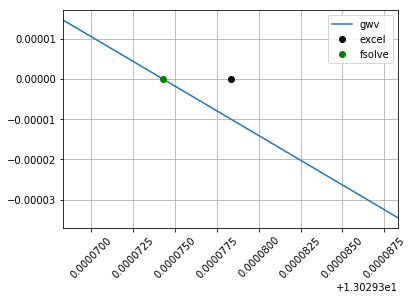

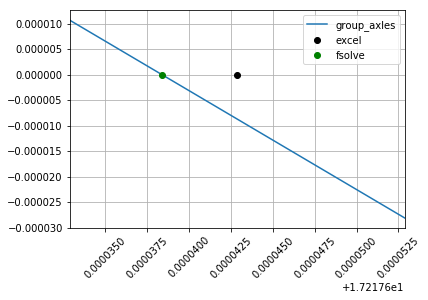

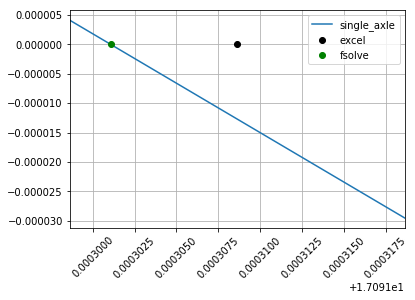

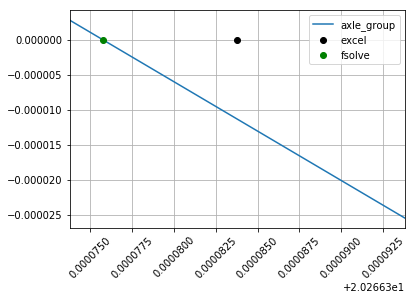

In [21]:
# show graphical visualization about the solver function to achieve the 
# mininum tolerance

# data sheet value
data_y = [
    13.0293783341772,
    17.2176428723888,
    17.0913086307026,
    20.2663837816549
]

_delta = 1e-5

lims = [
    (data_y[0]-_delta, data_y[0]+_delta),
    (data_y[1]-_delta, data_y[1]+_delta),
    (data_y[2]-_delta, data_y[2]+_delta),
    (data_y[3]-_delta, data_y[3]+_delta),
]

for k, s in data.T.items():
    _number = s['number']
    _mean = s['mean']
    _std = s['std']
    _min_confidence = s['min_confidence']
    
    _factor = stats.t.isf(0.05/2, _number-1)/np.sqrt(_number)
    _dof = _number-1

    func = lambda _min_tolerance: _min_confidence-100*(
        1-
        stats.t.sf(
            (_min_tolerance/_std-_mean/_std)-_factor, _dof)-
        stats.t.sf(
            (_min_tolerance/_std+_mean/_std)-_factor, _dof)
    )
    
    xlim = lims.pop(0)
    x = np.linspace(xlim[0], xlim[1], 1000)
    
    ax = plt.figure().gca()   
    
    data_func = pd.DataFrame({k: [func(xi) for xi in x]}, index=x)
    data_func.plot(ax=ax)
    
    ax.plot(data_y.pop(0), 0, 'o', label='excel', color='black')
    ax.plot(fsolve(func, 1), 0, 'o', label='fsolve', color='green')
    
    ax.legend()
    
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    
    plt.grid(True)
    plt.show()

# References

(<a id="cit-jacob1998european" href="#call-jacob1998european">JACOB and O'Brien, 1998</a>) B. JACOB and E.J. O'Brien, ``_European Specification on Weigh-In-Motion of Road Vehicles (COST323)_'', SECOND EUROPEAN CONFERENCE ON WEIGH-IN-MOTION OF ROAD VEHICLES, HELD LISBON, PORTUGAL 14-16 SEPTEMBER 1998,  1998.

